In [1]:
from mutag import Mutagenicity
from torch_geometric.loader import DataLoader


train_set = Mutagenicity(mode='training')
test_set = Mutagenicity(mode='testing')
validate_set = Mutagenicity(mode='evaluation')

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=16)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True, num_workers=16)
validate_loader = DataLoader(validate_set, batch_size=64, shuffle=True, num_workers=16)

In [2]:
import torch
from models import GcnEncoderGraph
from cider import CIDER

device = torch.device('cuda')

task_model = GcnEncoderGraph(input_dim=train_set.num_features,
                                     hidden_dim=50,
                                     embedding_dim=10,
                                     num_layers=3,
                                     pred_hidden_dims=[10, 10],
                                     label_dim=2).to(device)

explainer_model = CIDER(train_set.num_features,
                                hidden_channels1=32,
                                hidden_channels2=64,
                                hidden_channels3=10,
                                task_model=task_model).to(device)

In [ ]:
path = './params/mutag_net.pt'
task_model.load_state_dict(torch.load(path))

In [4]:
path = './params/explainer_mutag.ckpt'
explainer_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
lr = 1e-4

optimizer = torch.optim.Adam(explainer_model.parameters(),
                                lr=lr,
                                weight_decay=1e-5)

In [ ]:
class DynamicObject:
    def __init__(self, **kwargs):
        # Initialize the object with any provided properties
        for key, value in kwargs.items():
            setattr(self, key, value)

args = DynamicObject()

In [ ]:
args.N = 5
args.alpha_r = 0.01
args.alpha_c = 0.1
args.alpha_kld = 1
args.alpha_reg = 0.1
args.alpha_diff = 1
args.random_sparsity = 0.8

In [ ]:
best_result = {}
test_result = {}
for epoch in range(args.start_epoch, args.epochs):
    losses = train_one_epoch(train_loader, explainer_model,
                                CrossEntropyLoss(), BCEWithLogitsLoss(),
                                optimizer, task_model, epoch, args)
    if args.writer:
        for key, value in losses.items():
            writer.add_scalar("train/" + key, value, epoch)
        writer.add_scalars("train/losses", losses, epoch)

    if epoch % 50 == 0:
        result_val = validate(val_set,
                                explainer_model,
                                explainer_model.task_model,
                                batch_size=args.batch_size * args.N)
        if args.writer:
            writer.add_scalars("validate/test set acc", result_val, epoch)
        print('epoch ', str(epoch), ':', result_val)


        if sum(result_val.values()) > sum(best_result.values()):
            best_result = result_val
            test_result = validate(test_set,
                                    explainer_model,
                                    explainer_model.task_model,
                                    batch_size=args.batch_size * args.N)
            torch.save(
                explainer_model.state_dict(),
                os.path.join('./params/explainer_' + args.dataset +
                                '.ckpt'))
            print('best result:', best_result)
            print('test result:', test_result)
    torch.cuda.empty_cache()

In [5]:
index = 0
data = train_set[index]
train_set[index].y

tensor([0])

In [7]:
explainations = explainer_model.get_explainations(data.x.to(device), data.edge_index.to(device))

In [ ]:
from utils import validate

validate(test_set, explainer_model, task_model)

In [6]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

In [ ]:
train_set[index]

In [ ]:
explainations['0.1'].edge_index,explainations['0.1'].edge_index.shape

In [7]:
colors = ['orange', 'lime', 'red', 'blue', 'maroon', 'brown', 'darkslategray', 'paleturquoise', 'darksalmon', 'slategray', 'mediumseagreen', 'mediumblue', 'orchid']

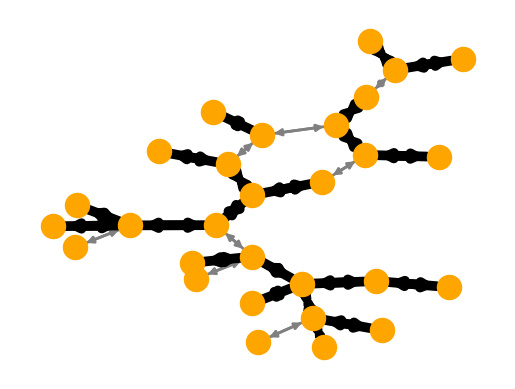

<Figure size 640x480 with 0 Axes>

In [8]:
explaination = to_networkx(explainations['0.1'])
G = to_networkx(train_set[index])
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx_nodes(G, pos, nodelist=[i for i in range(train_set[index].num_nodes)], node_color=colors[0], node_size=300)

nx.draw_networkx_edges(G, pos, width=2, edge_color='grey')

nx.draw_networkx_edges(G, pos, edgelist=explaination.edges, width=7)

plt.axis('off')
plt.show()
plt.clf()